# **Neural Style Transfer**

In [2]:
!pip install tensorflow matplotlib

Content image shape: (1, 224, 224, 3)
Style image shape: (1, 224, 224, 3)
Epoch: 1, Total Loss: 16.496387481689453
Epoch: 2, Total Loss: 13.983501434326172
Epoch: 3, Total Loss: 12.619549751281738
Epoch: 4, Total Loss: 12.042684555053711
Epoch: 5, Total Loss: 14.405643463134766
Epoch: 6, Total Loss: 11.656951904296875
Epoch: 7, Total Loss: 12.098430633544922
Epoch: 8, Total Loss: 11.213321685791016
Epoch: 9, Total Loss: 10.893030166625977
Epoch: 10, Total Loss: 17.564308166503906
Epoch: 11, Total Loss: 10.847244262695312
Epoch: 12, Total Loss: 10.63058853149414
Epoch: 13, Total Loss: 10.929471969604492
Epoch: 14, Total Loss: 10.946907043457031
Epoch: 15, Total Loss: 10.448954582214355
Epoch: 16, Total Loss: 10.246675491333008
Epoch: 17, Total Loss: 16.8702449798584
Epoch: 18, Total Loss: 10.39278793334961
Epoch: 19, Total Loss: 10.604774475097656
Epoch: 20, Total Loss: 10.270706176757812
Epoch: 21, Total Loss: 10.303095817565918
Epoch: 22, Total Loss: 10.419593811035156
Epoch: 23, Tota

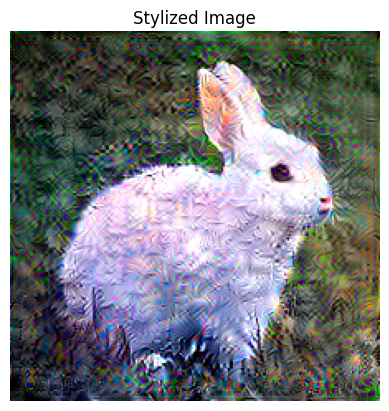

Image saved to stylized_image.jpg


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_and_process_img(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))  # Resize to match VGG19 input size
    img = np.array(img) / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to display images
def display_img(img, title=None):
    img = img.squeeze()  # Remove batch dimension
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Function to save an image
def save_img(img, file_path):
    img = img.squeeze()  # Remove batch dimension
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    img = (img * 255).astype(np.uint8)  # Convert to [0, 255] and uint8
    Image.fromarray(img).save(file_path)

# Load images from local files
content_img_path = 'rabbit.jpg'
style_img_path = 'van.jpg'

content_img = load_and_process_img(content_img_path)
style_img = load_and_process_img(style_img_path)

# Check shapes of the images
print(f"Content image shape: {content_img.shape}")
print(f"Style image shape: {style_img.shape}")

# Function to compute the Gram matrix
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])  # Reshape to [N, C]
    return tf.matmul(a, a, transpose_a=True) / tf.cast(tf.shape(tensor)[1] * tf.shape(tensor)[2], tf.float32)

# Neural Style Transfer Implementation
def style_transfer(content_img, style_img, epochs=10, steps_per_epoch=100):
    # Load VGG19 model
    base_model = keras.applications.VGG19(include_top=False, weights='imagenet')

    # Define the layers to be used for style and content extraction
    content_layer = 'block5_conv2'  # Example content layer
    style_layers = [
        'block1_conv1',
        'block2_conv1',
        'block3_conv1',
        'block4_conv1',
        'block5_conv1'
    ]

    # Create model for style and content outputs
    outputs = [base_model.get_layer(name).output for name in style_layers + [content_layer]]
    model = keras.Model(inputs=base_model.input, outputs=outputs)

    # Compute the content and style representations
    content_target = model(content_img)[-1]  # Content representation
    style_targets = model(style_img)[:-1]  # Style representations

    # Initialize generated image
    generated_img = tf.Variable(content_img)

    # Define the optimizer
    optimizer = keras.optimizers.Adam(learning_rate=0.02)

    # Loss weights
    content_weight = 1e3
    style_weight = 1e-2

    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            with tf.GradientTape() as tape:
                # Compute the outputs for the generated image
                outputs = model(generated_img)

                # Compute content loss
                content_output = outputs[-1]
                content_loss = tf.reduce_mean(tf.square(content_output - content_target))

                # Compute style loss
                style_loss = 0
                for target, output in zip(style_targets, outputs[:-1]):
                    style_loss += tf.reduce_mean(tf.square(gram_matrix(output) - gram_matrix(target)))

                # Total loss
                total_loss = content_weight * content_loss + style_weight * style_loss

            # Compute gradients and update the generated image
            grads = tape.gradient(total_loss, generated_img)
            optimizer.apply_gradients([(grads, generated_img)])

        if epoch % 1 == 0:
            print(f"Epoch: {epoch + 1}, Total Loss: {total_loss.numpy()}")

    return generated_img

# Run style transfer
result = style_transfer(content_img, style_img, epochs=30, steps_per_epoch=100)

# Clamp values to [0, 1] to avoid clipping issues
result_clamped = tf.clip_by_value(result, 0.0, 1.0)

# Display the generated image
display_img(result_clamped.numpy(), title="Stylized Image")

# Save the generated image
output_image_path = 'stylized_image.jpg'
save_img(result_clamped.numpy(), output_image_path)
print(f"Image saved to {output_image_path}")
